In [1]:
# 预处理

In [1]:
# 预处理步骤
# 1.读取NIFTI格式的文件，加载其中图片和mask
# 2.显示一层图片（包含mask）
# 3.动态显示整个扫描（显示一个文件的多层图像信息）
# 4.构造归一化、标准化的函数
# 5.预处理所有文件，保存为np文件，存在磁盘
# 6.检查一下存储的np文件是否合格

In [2]:
# 导入相关包
import nibabel as nib

In [3]:
# 挑一个文件测试
test_file = './data/imagesTr/la_018.nii.gz'

# 对应的mask标注
test_mask = './data/labelsTr/la_018.nii.gz'

In [4]:
# nibabel读取图像信息和mask
img = nib.load(test_file)
mask = nib.load(test_mask)

In [5]:
# 获取其中数据
img_data = img.get_fdata()
mask_data = mask.get_fdata()

In [6]:
# 查看大小
print(img_data.shape)
print(mask_data.shape)

(320, 320, 122)
(320, 320, 122)


In [7]:
# 显示图片
import matplotlib.pyplot as plt
import numpy as np

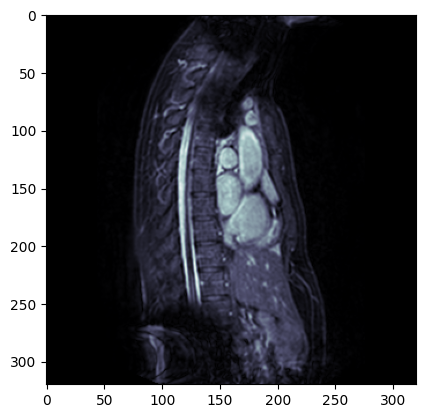

In [8]:
plt.imshow(np.rot90(img_data[:,:,80]),cmap='bone')

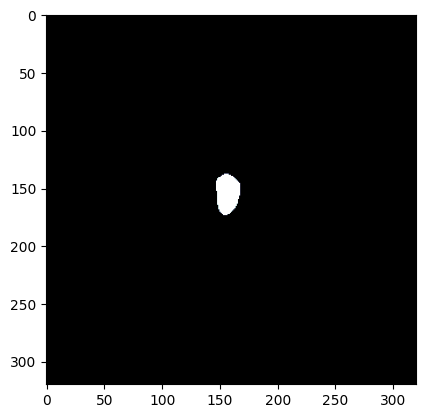

In [9]:
plt.imshow(np.rot90(mask_data[:,:,80]),cmap='bone')

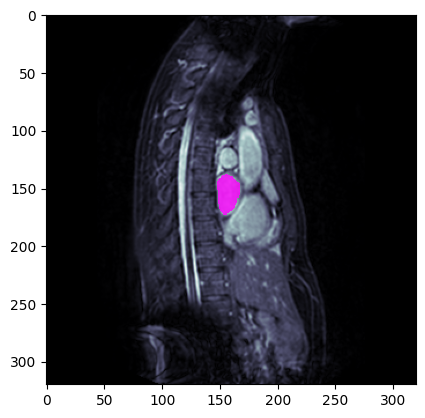

In [10]:
# 将mask和图片绘制在一起
img_display = np.rot90(img_data[:,:,80])
mask_display = np.rot90(mask_data[:,:,80])   
# 将mask_display像素值为0处遮挡起来
mask = np.ma.masked_where(mask_display==0,mask_display)
plt.imshow(img_display,cmap='bone')
plt.imshow(mask,alpha=0.8,cmap='spring')

In [11]:
#将122层画面合成为动画
from celluloid  import Camera
from IPython.display import HTML
import tqdm

In [12]:
img_data.shape

(320, 320, 122)

100%|███████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 215.07it/s]


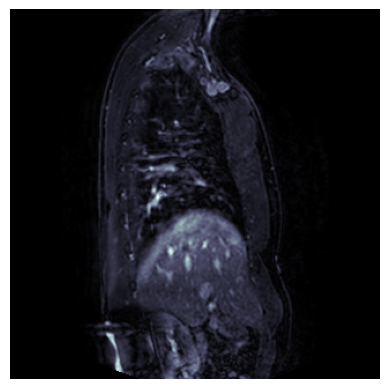

In [13]:
#遍历每一层图像和mask
fig = plt.figure()
camera = Camera(fig)

for i in tqdm.tqdm( range(img_data.shape[-1]) ):
    
    # 将mask和图片绘制在一起
    img_display = np.rot90(img_data[:,:,i])
    mask_display = np.rot90(mask_data[:,:,i])   
    # 将mask_display像素值为0处遮挡起来
    mask = np.ma.masked_where(mask_display==0,mask_display)
    plt.imshow(img_display,cmap='bone')
    plt.imshow(mask,alpha=0.8,cmap='spring')
    
    plt.axis('off')
    
    camera.snap()


In [14]:
animation = camera.animate()

In [15]:
# 显示动画
HTML(animation.to_html5_video()) # conda install -c conda-forge ffmpeg

In [16]:
img_data.shape

(320, 320, 122)

In [17]:
img_data.max(),img_data.min()

(2095.0, 0.0)

In [18]:
# 归一化标准化

### 标准化
$$ x' = \frac{x-mean(x)}{\sigma} $$
### 归一化
$$ x' = \frac{x-min(x)}{max(x)-min(x)} $$

In [19]:
#标准化
def standardize(data):
    # 计算均值
    mean = data.mean()
    # 计算标准差
    std = np.std(data)
    
    # 计算结果
    standardized = (data - mean) / std
    return standardized


#  归一化
def normalize(data):
    # 计算最大值和最小值
    max_val = data.max()
    min_val = data.min()
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

In [20]:
test_data  = img_data[:,:,80]

In [21]:
std = standardize(test_data)

In [22]:
std.max(),std.min()

(5.628479883541003, -0.6118425303834774)

In [23]:
normalize(std).max(),normalize(std).min()

(1.0, 0.0)

In [24]:
# 处理所有文件

In [25]:
import glob
import os

In [26]:
# 获取文件列表（图片和标注）

In [27]:
train_file_list = glob.glob('data/imagesTr/la*')
train_label_list = glob.glob('data/labelsTr/la*')

In [28]:
len(train_file_list),len(train_label_list)

(20, 20)

In [29]:
# 遍历每隔文件，每隔文件包含多层图像，保存为np文件
for index,file  in enumerate(train_file_list):
    
    #读取文件和Label
    # 裁剪边缘，最终输出为256 x 256的图片
    # 标准化和归一化
    # 存入文件夹
    
    
    # 读取
    img = nib.load(file)
    mask = nib.load(train_label_list[index])
    
    img_data = img.get_fdata()
    mask_data = img.get_fdata()
    
    # 裁剪边缘
    img_data_crop = img_data[32:-32,32:-32]
    mask_data_crop = mask_data[32:-32,32:-32]
    
    # 标准化和归一化
    std = standardize(img_data_crop)
    normalized = normalize(std)
    
    #rint(normalized.shape)
    
    # 分成训练集和测试集
    if index < 17:
        # 当成训练集
        save_dir = 'processed/train/'
    else:
        # 当成测试集
        save_dir = 'processed/test/'
        
        
    # 遍历一个文件的所有层，每一层单独挑出来存储进文件夹，路径格式：'processed/train/0/img_0.npy','processed/train/0/label_0.npy'
    # train,test 表示训练集和测试集
    # train/0，中的0 表示文件序号
    # img_0.npy，label_0.npy 分别代表该文件的第1层图像以及对应的标注
    
    # 获取层数
    layer_num = normalized.shape[-1]
    # 遍历每一层
    for i in range(layer_num):
        # 获取第i层图像及标注
        layer = normalized[:,:,i]
        mask = mask_data_crop[:,:,i]
        
        # 创建文件夹
        img_dir = save_dir + str(index)
        # 如没有文件夹，则创建
        if not os.path.exists(img_dir):
            os.makedirs(img_dir)
        
        # 保存numpy文件
        np.save(img_dir + '/img_'+str(i), layer )
        np.save(img_dir + '/label_'+str(i), mask )
        
    
    
    
    
    
    
    
    # break

In [30]:
# 检查一组数据是否合格

In [31]:
# 解决列表排序问题
from natsort import natsorted # pip install natsort

In [32]:
img_test =natsorted(  glob.glob('processed/train/15/img*') )
label_test =natsorted( glob.glob('processed/train/15/label*') )

In [33]:
len(img_test),len(label_test)

(110, 110)

In [34]:
img_test[:50]

['processed/train/15\\img_0.npy',
 'processed/train/15\\img_1.npy',
 'processed/train/15\\img_2.npy',
 'processed/train/15\\img_3.npy',
 'processed/train/15\\img_4.npy',
 'processed/train/15\\img_5.npy',
 'processed/train/15\\img_6.npy',
 'processed/train/15\\img_7.npy',
 'processed/train/15\\img_8.npy',
 'processed/train/15\\img_9.npy',
 'processed/train/15\\img_10.npy',
 'processed/train/15\\img_11.npy',
 'processed/train/15\\img_12.npy',
 'processed/train/15\\img_13.npy',
 'processed/train/15\\img_14.npy',
 'processed/train/15\\img_15.npy',
 'processed/train/15\\img_16.npy',
 'processed/train/15\\img_17.npy',
 'processed/train/15\\img_18.npy',
 'processed/train/15\\img_19.npy',
 'processed/train/15\\img_20.npy',
 'processed/train/15\\img_21.npy',
 'processed/train/15\\img_22.npy',
 'processed/train/15\\img_23.npy',
 'processed/train/15\\img_24.npy',
 'processed/train/15\\img_25.npy',
 'processed/train/15\\img_26.npy',
 'processed/train/15\\img_27.npy',
 'processed/train/15\\img_28.n

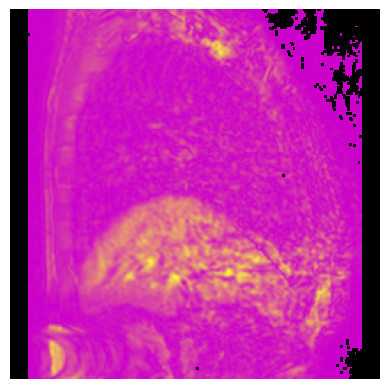

In [35]:
#遍历每一层图像和mask
fig = plt.figure()
camera = Camera(fig)

for index,img_file in enumerate(img_test):
    
    # 加载图片
    img_data = np.load(img_file)
    mask_data = np.load(label_test[index])
    
    # 将mask和图片绘制在一起
    img_display = np.rot90(img_data)
    mask_display = np.rot90(mask_data)   
    # 将mask_display像素值为0处遮挡起来
    mask = np.ma.masked_where(mask_display==0,mask_display)
    plt.imshow(img_display,cmap='bone')
    plt.imshow(mask,alpha=0.8,cmap='spring')
    
    plt.axis('off')
    
    camera.snap()

    
    

In [36]:
animation = camera.animate()

In [37]:
HTML(animation.to_html5_video())